In [1]:
import os
import sys

os.environ["SPARK_HOME"] = "/usr/spark2.4.3"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
os.environ["PYSPARK_PYTHON"] = "/usr/local/anaconda/bin/python" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/local/anaconda/bin/python"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")
 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from functools import reduce
from pyspark.sql.functions import col, lit, when

#import required libraries
import numpy as np
import pyspark


#Create Spark session
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark)

# Import libraries and other functions
from io import StringIO
from collections import namedtuple
from pyspark.sql import Row
from pyspark.sql.types import *
from pyspark.sql.functions import *

import csv
import matplotlib.pyplot as plt
import gmplot
import pandas as pd

# Create "Accidents/Casualty and Vehicle" DataFrame

In [2]:
#create a DataFrame directly from "dft-road-casualty-statistics-accident" csv files for last 5 years 

accident_5Years = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").csv("hdfs:///user/imat5322_376434/*-statistics-accident-*.csv")

#create a DataFrame directly from "dft-road-casualty-statistics-casualty" csv files for last 5 years  

casualty_5Years = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").csv("hdfs:///user/imat5322_376434/*-statistics-casualty-*.csv")

#create a DataFrame directly from "dft-road-casualty-statistics-vehicle" csv files for last 5 years  

vehicle_5Years = spark.read.option("header", "true").option("delimiter", ",")\
.option("inferSchema", "true").csv("hdfs:///user/imat5322_376434/*-statistics-vehicle-*.csv")

In [3]:
# Count rows of the dataframe accidents_5Years
accident_5Years.count()

597973

In [4]:
# Count rows the dataframe casualty_5Years
casualty_5Years.count()

781716

In [5]:
# Count rows of the dataframe vehicle_5Years
vehicle_5Years.count()

1101591

In [6]:
# Display the dataframe accident_5Years
accident_5Years.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- location_easting_osgr: string (nullable = true)
 |-- location_northing_osgr: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- police_force: integer (nullable = true)
 |-- accident_severity: integer (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- day_of_week: integer (nullable = true)
 |-- time: string (nullable = true)
 |-- local_authority_district: integer (nullable = true)
 |-- local_authority_ons_district: string (nullable = true)
 |-- local_authority_highway: string (nullable = true)
 |-- first_road_class: integer (nullable = true)
 |-- first_road_number: integer (nullable = true)
 |-- road_type: integer (nullable = true)
 |-- speed_limit: string (nullable = 

In [7]:
# Display the dataframe accident_5Years
casualty_5Years.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- casualty_reference: integer (nullable = true)
 |-- casualty_class: integer (nullable = true)
 |-- sex_of_casualty: integer (nullable = true)
 |-- age_of_casualty: integer (nullable = true)
 |-- age_band_of_casualty: integer (nullable = true)
 |-- casualty_severity: integer (nullable = true)
 |-- pedestrian_location: integer (nullable = true)
 |-- pedestrian_movement: integer (nullable = true)
 |-- car_passenger: integer (nullable = true)
 |-- bus_or_coach_passenger: integer (nullable = true)
 |-- pedestrian_road_maintenance_worker: integer (nullable = true)
 |-- casualty_type: integer (nullable = true)
 |-- casualty_home_area_type: integer (nullable = true)
 |-- casualty_imd_decile: integer (nullable = true)



In [8]:
#Print the schema structure of dataframe accident_5Years
vehicle_5Years.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- accident_reference: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- vehicle_type: integer (nullable = true)
 |-- towing_and_articulation: integer (nullable = true)
 |-- vehicle_manoeuvre: integer (nullable = true)
 |-- vehicle_direction_from: integer (nullable = true)
 |-- vehicle_direction_to: integer (nullable = true)
 |-- vehicle_location_restricted_lane: integer (nullable = true)
 |-- junction_location: integer (nullable = true)
 |-- skidding_and_overturning: integer (nullable = true)
 |-- hit_object_in_carriageway: integer (nullable = true)
 |-- vehicle_leaving_carriageway: integer (nullable = true)
 |-- hit_object_off_carriageway: integer (nullable = true)
 |-- first_point_of_impact: integer (nullable = true)
 |-- vehicle_left_hand_drive: integer (nullable = true)
 |-- journey_purpose_of_driver: integer (nullable = true)
 |-- sex_of_driver: integer

In [9]:
accident_5Years.take(1)

[Row(accident_index='2016010000005', accident_year=2016, accident_reference='010000005', location_easting_osgr='519310', location_northing_osgr='188730', longitude='-0.279323', latitude='51.584754', police_force=1, accident_severity=3, number_of_vehicles=2, number_of_casualties=1, date='01/11/2016', day_of_week=3, time='02:30', local_authority_district=28, local_authority_ons_district='E09000005', local_authority_highway='E09000005', first_road_class=3, first_road_number=4006, road_type=6, speed_limit='30', junction_detail=0, junction_control=-1, second_road_class=-1, second_road_number=-1, pedestrian_crossing_human_control=0, pedestrian_crossing_physical_facilities=0, light_conditions=5, weather_conditions=1, road_surface_conditions=1, special_conditions_at_site=0, carriageway_hazards=0, urban_or_rural_area=1, did_police_officer_attend_scene_of_accident=1, trunk_road_flag=2, lsoa_of_accident_location='E01000543')]

In [10]:
vehicle_5Years.take(1)

[Row(accident_index='2016010000005', accident_year=2016, accident_reference='010000005', vehicle_reference=1, vehicle_type=8, towing_and_articulation=0, vehicle_manoeuvre=6, vehicle_direction_from=3, vehicle_direction_to=7, vehicle_location_restricted_lane=0, junction_location=0, skidding_and_overturning=0, hit_object_in_carriageway=0, vehicle_leaving_carriageway=0, hit_object_off_carriageway=0, first_point_of_impact=3, vehicle_left_hand_drive=1, journey_purpose_of_driver=1, sex_of_driver=1, age_of_driver=51, age_band_of_driver=8, engine_capacity_cc=-1, propulsion_code=-1, age_of_vehicle=-1, generic_make_model='-1', driver_imd_decile=3, driver_home_area_type=1)]

In [11]:
casualty_5Years.take(1)

[Row(accident_index='2016010000005', accident_year=2016, accident_reference='010000005', vehicle_reference=2, casualty_reference=1, casualty_class=1, sex_of_casualty=1, age_of_casualty=23, age_band_of_casualty=5, casualty_severity=3, pedestrian_location=0, pedestrian_movement=0, car_passenger=0, bus_or_coach_passenger=0, pedestrian_road_maintenance_worker=0, casualty_type=2, casualty_home_area_type=1, casualty_imd_decile=4)]

In [12]:
# Join dataframes by primary key

In [13]:
# joining accident_5Years with casualty_5Years on primary key="accident_index"

joned_acciddent_casualty=accident_5Years.join(casualty_5Years,
accident_5Years["accident_index"] == casualty_5Years["accident_index"],
how="Full").drop(casualty_5Years["accident_index"])

In [14]:
# joining joned_acciddent_casualty with vehicle_5Years on primary key="accident_index"
# joined_allDF is the joined dataframe of three dataframes

joined_dataframe=joned_acciddent_casualty.join(vehicle_5Years,
joned_acciddent_casualty["accident_index"] == vehicle_5Years["accident_index"],
how="Full")

In [15]:
#initialize the dataframe using take() function
joined_dataframe.take(1)

[Row(accident_index='2016010000053', accident_year=2016, accident_reference='010000053', location_easting_osgr='525750', location_northing_osgr='179560', longitude='-0.189693', latitude='51.500944', police_force=1, accident_severity=3, number_of_vehicles=1, number_of_casualties=1, date='01/11/2016', day_of_week=3, time='13:52', local_authority_district=12, local_authority_ons_district='E09000020', local_authority_highway='E09000020', first_road_class=6, first_road_number=0, road_type=6, speed_limit='30', junction_detail=0, junction_control=-1, second_road_class=-1, second_road_number=-1, pedestrian_crossing_human_control=0, pedestrian_crossing_physical_facilities=0, light_conditions=1, weather_conditions=1, road_surface_conditions=1, special_conditions_at_site=0, carriageway_hazards=0, urban_or_rural_area=1, did_police_officer_attend_scene_of_accident=1, trunk_road_flag=2, lsoa_of_accident_location='E01002889', accident_year=2016, accident_reference='010000053', vehicle_reference=1, ca

In [16]:
# Drop ambiguous colums which are repeated after joining.

joined_allDF_after_cleaning=joined_dataframe.drop(casualty_5Years["accident_year"]) \
                                    .drop(vehicle_5Years["accident_year"]) \
                                    .drop(casualty_5Years["accident_reference"]) \
                                    .drop(vehicle_5Years["accident_reference"]) \
                                    .drop(vehicle_5Years["vehicle_reference"]) \
                                    .drop(vehicle_5Years["accident_index"])
                                    

In [17]:
#Checking the number of columns of final joined DF

print("Total columns of joined_DF.columns \
is " + str(len(joined_allDF_after_cleaning.columns)))

Total columns of joined_DF.columns is 74


In [18]:

#Dropping unwanted columns

joined_allDF_after_cleaning1=joined_allDF_after_cleaning.drop("driver_home_area_type") \
                                    .drop("driver_imd_decile").drop("police_force") \
                                    .drop("local_authority_district").drop("local_authority_ons_district") \
                                    .drop("local_authority_highway").drop("first_road_class") \
                                    .drop("first_road_number").drop("junction_detail") \
                                    .drop("junction_control").drop("second_road_class") \
                                    .drop("second_road_number").drop("pedestrian_crossing_human_control") \
                                    .drop("pedestrian_crossing_physical_facilities").drop("did_police_officer_attend_scene_of_accident") \
                                    .drop("pedestrian_location").drop("towing_and_articulation") \
                                    .drop("vehicle_direction_from").drop("vehicle_direction_to") \
                                    .drop("junction_location").drop("propulsion_code") \
                                    .drop("driver_imd_decile").drop("driver_home_area_type") \
                                    .drop("location_easting_osgr").drop("location_northing_osgr") \
                                    .drop("accident_reference").drop("carriageway_hazards") \
                                    .drop("trunk_road_flag").drop("vehicle_location_restricted_lane") \
                                    .drop("hit_object_in_carriageway").drop("hit_object_off_carriageway") \
                                    .drop("vehicle_left_hand_drive").drop("pedestrian_movement") \
                                    .drop("bus_or_coach_passenger").drop("pedestrian_road_maintenance_worker") \
                                    .drop("casualty_type").drop("casualty_imd_decile")


In [19]:
#Checking the number of columns of final joined DF

print("Total columns of joined_DF.columns \
is " + str(len(joined_allDF_after_cleaning1.columns)))

Total columns of joined_DF.columns is 39


In [ ]:
# Check Supporting Data to use to translate keys to meaningful terms (lookup table)
# https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data


In [20]:
#Convert numerical column values into meaningful data

from pyspark.sql.functions import regexp_replace 

joined_DF = joined_allDF_after_cleaning1. \
withColumn("accident_severity", regexp_replace("accident_severity" , "1" ,"Fatal")). \
withColumn("accident_severity", regexp_replace("accident_severity" , "2" ,"Serious")). \
withColumn("accident_severity", regexp_replace("accident_severity" , "3" ,"Slight")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","1","Sunday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","2","Monday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","3","Tuesday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","4","Wednessday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","5","Thursday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","6","Friday")). \
withColumn("Day_of_Week", regexp_replace("Day_of_Week","7","Saturday")). \
withColumn("road_type", regexp_replace("road_type","1","Roundabout")). \
withColumn("road_type", regexp_replace("road_type","2","One way street")). \
withColumn("road_type", regexp_replace("road_type","3","Dual carriageway")). \
withColumn("road_type", regexp_replace("road_type","6","Single carriageway")). \
withColumn("road_type", regexp_replace("road_type","7","Slip road")). \
withColumn("road_type", regexp_replace("road_type","9","Unknown")). \
withColumn("road_type", regexp_replace("road_type","12","One way street/Slip road")). \
withColumn("road_type", regexp_replace("road_type","-1","Data missing or out of range")). \
withColumn("light_conditions", regexp_replace("light_conditions","1","Daylight")). \
withColumn("light_conditions", regexp_replace("light_conditions","4","Darkness - lights lit")). \
withColumn("light_conditions", regexp_replace("light_conditions","5","Darkness - lights unlit")). \
withColumn("light_conditions", regexp_replace("light_conditions","6","Darkness - no lighting")). \
withColumn("light_conditions", regexp_replace("light_conditions","7","Darkness - lighting known")). \
withColumn("light_conditions", regexp_replace("light_conditions","-1","Data missing or out of range")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","-1","Data missing or out of range")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","1","Fine no high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","2","Raining no high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","3","Snowing no high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","4","Fine + high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","5","Raining + high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","6","Snowing + high winds")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","7","Fog or mist")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","8","Other")). \
withColumn("weather_conditions", regexp_replace("weather_conditions","9","Unknown")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","1","Dry")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","2","Wet or damp")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","3","Snow")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","4","Frost or ice")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","5","Flood over 3cm. deep")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","6","Oil or diesel")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","7","Mud")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","-1","Data missing or out of range")). \
withColumn("road_surface_conditions", regexp_replace("road_surface_conditions","9","Unknown")). \
withColumn("urban_or_rural_area", regexp_replace("urban_or_rural_area","1","Urban")). \
withColumn("urban_or_rural_area", regexp_replace("urban_or_rural_area","2","Rural")). \
withColumn("urban_or_rural_area", regexp_replace("urban_or_rural_area","3","Unallocated")). \
withColumn("urban_or_rural_area", regexp_replace("urban_or_rural_area","-1","Data missing or out of range")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","0","None")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","1","Auto traffic signal - out")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","2","Auto signal part defective")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","3","Road sign or marking defective or obscured")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","4","Roadworks")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","5","Road surface defective")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","6","Oil or diesel")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","7","Mud")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","9","Unknown")). \
withColumn("special_conditions_at_site", regexp_replace("special_conditions_at_site","-1","Data missing or out of range")). \
withColumn("casualty_severity", regexp_replace("casualty_severity","1","Fatal")). \
withColumn("casualty_severity", regexp_replace("casualty_severity","2","Serious")). \
withColumn("casualty_severity", regexp_replace("casualty_severity","3","Slight")). \
withColumn("casualty_class", regexp_replace("casualty_class","1","Driver or rider")). \
withColumn("casualty_class", regexp_replace("casualty_class","2","Passenger")). \
withColumn("casualty_class", regexp_replace("casualty_class","3","Pedestrian")). \
withColumn("sex_of_casualty", regexp_replace("sex_of_casualty","1","Male")). \
withColumn("sex_of_casualty", regexp_replace("sex_of_casualty","2","Female")). \
withColumn("sex_of_casualty", regexp_replace("sex_of_casualty","9","Unknown")). \
withColumn("sex_of_casualty", regexp_replace("sex_of_casualty","-1","Missing Data")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","1","0-5")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","2","6-10")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","3","11-15")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","4","16-20")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","5","21-25")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","6","26-35")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","7","36-45")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","8","46-55")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","9","56-65")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","10","66-75")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","11","Over 75")). \
withColumn("age_band_of_casualty", regexp_replace("age_band_of_casualty","-1","Missing Data")). \
withColumn("car_passenger", regexp_replace("car_passenger","0","Not car passenger")). \
withColumn("car_passenger", regexp_replace("car_passenger","1","Front seat passenger")). \
withColumn("car_passenger", regexp_replace("car_passenger","2","Rear seat passenger")). \
withColumn("car_passenger", regexp_replace("car_passenger","9","Unknown")). \
withColumn("car_passenger", regexp_replace("car_passenger","-1","Missing Data")). \
withColumn("sex_of_driver", regexp_replace("sex_of_driver","1","Male")). \
withColumn("sex_of_driver", regexp_replace("sex_of_driver","2","Female")). \
withColumn("sex_of_driver", regexp_replace("sex_of_driver","3","Unknown")). \
withColumn("sex_of_driver", regexp_replace("sex_of_driver","-1","Data missing or out of range")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","1","0-5")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","2","6-10")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","3","11-15")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","4","16-20")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","5","21-25")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","6","26-35")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","7","36-45")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","8","46-55")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","9","56-65")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","10","66-75")). \
withColumn("age_band_of_driver", regexp_replace("age_band_of_driver","11","Over 75")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","1","As part of work")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","2","Commuting to/from work")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","3","Taking pupil to/from school")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","4","Pupil riding to/from school")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","5","Other")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","6","Not known")). \
withColumn("Journey_Purpose_of_Driver", regexp_replace("Journey_Purpose_of_Driver","15","Other")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","0","No impact")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","1","Front")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","2","Back")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","3","Offside")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","4","Nearside")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","9","Unknown")). \
withColumn("first_point_of_impact", regexp_replace("first_point_of_impact","-1","Data missing"))












                                            
                                                 



In [21]:
# Print the final joined dataframe schema details
joined_DF.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- accident_severity: string (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- time: string (nullable = true)
 |-- road_type: string (nullable = true)
 |-- speed_limit: string (nullable = true)
 |-- light_conditions: string (nullable = true)
 |-- weather_conditions: string (nullable = true)
 |-- road_surface_conditions: string (nullable = true)
 |-- special_conditions_at_site: string (nullable = true)
 |-- urban_or_rural_area: string (nullable = true)
 |-- lsoa_of_accident_location: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- casualty_reference: integer (nullable = true)
 |-- casualty_class: string (nullable = true)
 |--

In [22]:
#Checking the number of columns of final joined DF

print("Total columns of joined_DF.columns \
is " + str(len(joined_DF.columns)))

Total columns of joined_DF.columns is 39


In [23]:
joined_DF.take(1)

[Row(accident_index='2016010000053', accident_year=2016, longitude='-0.189693', latitude='51.500944', accident_severity='Slight', number_of_vehicles=1, number_of_casualties=1, date='01/11/2016', Day_of_Week='Tuesday', time='13:52', road_type='Single carriageway', speed_limit='30', light_conditions='Daylight', weather_conditions='Fine no high winds', road_surface_conditions='Dry', special_conditions_at_site='None', urban_or_rural_area='Urban', lsoa_of_accident_location='E01002889', vehicle_reference=1, casualty_reference=1, casualty_class='Pedestrian', sex_of_casualty='Male', age_of_casualty=74, age_band_of_casualty='0-21-250', casualty_severity='Slight', car_passenger='Not car passenger', casualty_home_area_type=1, vehicle_type=19, vehicle_manoeuvre=1, skidding_and_overturning=0, vehicle_leaving_carriageway=0, first_point_of_impact='Back', Journey_Purpose_of_Driver='As part of work', sex_of_driver='Male', age_of_driver=52, age_band_of_driver='46-55', engine_capacity_cc=1998, age_of_veh

In [24]:
joined_DF.printSchema()

root
 |-- accident_index: string (nullable = true)
 |-- accident_year: integer (nullable = true)
 |-- longitude: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- accident_severity: string (nullable = true)
 |-- number_of_vehicles: integer (nullable = true)
 |-- number_of_casualties: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- time: string (nullable = true)
 |-- road_type: string (nullable = true)
 |-- speed_limit: string (nullable = true)
 |-- light_conditions: string (nullable = true)
 |-- weather_conditions: string (nullable = true)
 |-- road_surface_conditions: string (nullable = true)
 |-- special_conditions_at_site: string (nullable = true)
 |-- urban_or_rural_area: string (nullable = true)
 |-- lsoa_of_accident_location: string (nullable = true)
 |-- vehicle_reference: integer (nullable = true)
 |-- casualty_reference: integer (nullable = true)
 |-- casualty_class: string (nullable = true)
 |--

In [25]:

sqlContext.registerDataFrameAsTable(joined_DF, "joined_DF_table")

In [26]:
import pixiedust
display(joined_DF)

In [27]:

#initialize Counter to 0
i = 0 

#Total records in the joined_DF dataframe

total = joined_DF.count()

print("Total Records = " + str(total))

#Prints the total number of column

print("Total columns = " + str(len(joined_DF.columns)))
print("+++++++++++++++++++++++++++++++++++++++++")
print("+++++++++++++++++++++++++++++++++++++++++")

#while Loop used here to display the count of  each column's missing values 

while i < len(joined_DF.columns):                             
#Loop which checks every column
    print(str(i+1) + "." + str(joined_DF[i]))
    print("  Missing Values = ") 
   
    missingvalue1 = joined_DF.select([count(when(joined_DF[i].isNull(),True))]).show() 
    i = i+1 #Counter is incremented by 1

Total Records = 1512297
Total columns = 39
+++++++++++++++++++++++++++++++++++++++++
+++++++++++++++++++++++++++++++++++++++++
1.Column<b'accident_index'>
  Missing Values = 
+-------------------------------------------------------+
|count(CASE WHEN (accident_index IS NULL) THEN true END)|
+-------------------------------------------------------+
|                                                      0|
+-------------------------------------------------------+

2.Column<b'accident_year'>
  Missing Values = 
+------------------------------------------------------+
|count(CASE WHEN (accident_year IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+

3.Column<b'longitude'>
  Missing Values = 
+--------------------------------------------------+
|count(CASE WHEN (longitude IS NULL) THEN true END)|
+--------------------------------------------------+

+----------------------------------------------------------+
|count(CASE WHEN (casualty_severity IS NULL) THEN true END)|
+----------------------------------------------------------+
|                                                         0|
+----------------------------------------------------------+

26.Column<b'car_passenger'>
  Missing Values = 
+------------------------------------------------------+
|count(CASE WHEN (car_passenger IS NULL) THEN true END)|
+------------------------------------------------------+
|                                                     0|
+------------------------------------------------------+

27.Column<b'casualty_home_area_type'>
  Missing Values = 
+----------------------------------------------------------------+
|count(CASE WHEN (casualty_home_area_type IS NULL) THEN true END)|
+----------------------------------------------------------------+
|                                                               0|
+---------------------------------

# Visualisations

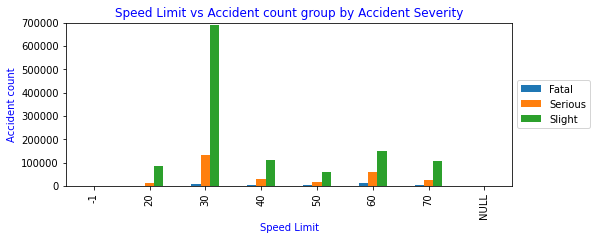

In [28]:
#Speed Limit vs Accident count group by Accident Severity


Accident_type = joined_DF.groupby("Accident_Severity","Speed_limit").count().sort("count")



import matplotlib.pyplot as plt
import pandas as pd

Panda_Accident_Type = Accident_type.toPandas()

%matplotlib inline



plot_Outcome=Panda_Accident_Type.pivot(index='Speed_limit', columns='Accident_Severity', values='count') \
                         .plot(kind='bar', figsize=(8,3))
plot_Outcome.set_title("Speed Limit vs Accident count group by Accident Severity",color="b")
plot_Outcome.set_ylim(0,700000)
plot_Outcome.set_xlabel("Speed Limit",color="b")
plot_Outcome.set_ylabel("Accident count",color="b")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

In [ ]:
#visualization for Speed Limit vs Casualty Severity

Accident_type = joined_DF.groupby("Speed_limit","casualty_severity").count().sort("count")
display(Accident_type)

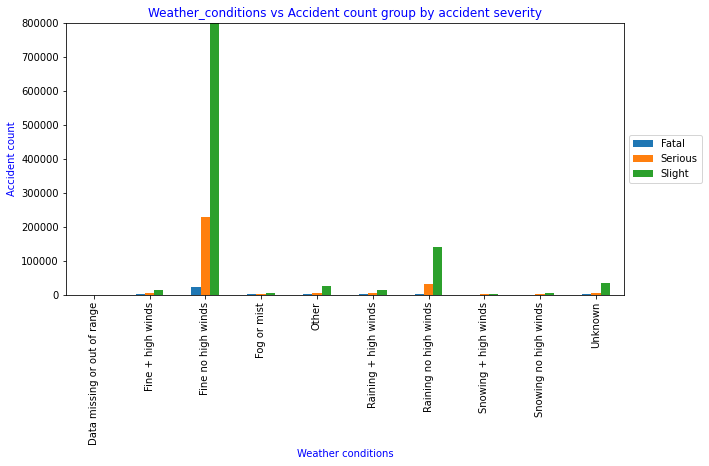

In [30]:
#visualiation for weather conditions vs Accident Severity

import numpy as np

Accident_type = joined_DF.groupby("weather_conditions","Accident_Severity") \
                                                        .count().sort("count")
Panda_Accident_Type = Accident_type.toPandas()

%matplotlib inline


plot_Outcome=Panda_Accident_Type.pivot(index='weather_conditions', columns='Accident_Severity', values='count') \
                         .plot(kind='bar', figsize=(10,5))
plot_Outcome.set_title("Weather_conditions vs Accident count group by accident severity",color="b")
plot_Outcome.set_ylim(0,800000)
plot_Outcome.set_xlabel("Weather conditions",color="b")
plot_Outcome.set_ylabel("Accident count",color="b")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));





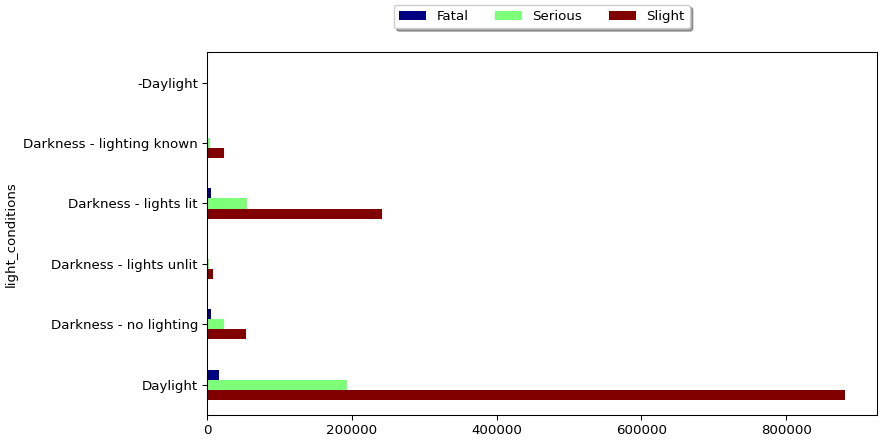

In [ ]:
# light condition vs 

Accident_type = joined_DF.groupby("light_conditions","accident_year","Accident_Severity").count().sort("count")
Accident_type.show()

display(Accident_type)






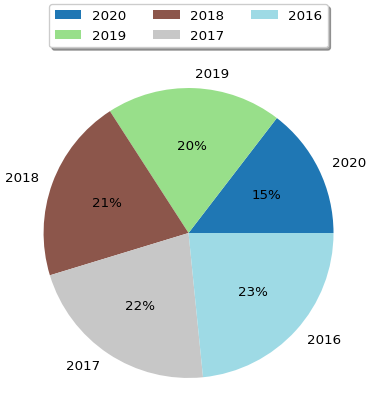

In [32]:
# Total percentage of accidents per year out of total accidents in 5 years

accident_count_year=joined_DF.groupby('accident_year').count().orderBy(desc("Count"))
display(accident_count_year)

In [34]:
#Accident density
#
accident_count_geo=sqlContext.sql("select latitude,longitude,count(*) as \
                                    Count from joined_DF_table group by latitude,longitude")
accident_count_geo.show()

+---------+---------+-----+
| latitude|longitude|Count|
+---------+---------+-----+
|51.448217| -0.10255|    2|
|54.150072|-3.178191|    2|
|51.100696| 0.131352|    2|
|50.254871|-5.056409|    2|
|51.550996|-0.260976|    2|
|53.056766|-0.784595|    2|
|51.317336| 0.294422|    1|
|52.576575|-1.453515|    4|
|51.437867| 0.225708|    4|
|53.426885|-2.132423|    2|
|51.545336| 0.103263|    4|
|51.589227|-0.108373|    2|
|51.409722|-2.317307|    2|
|50.705848|-4.062882|    2|
| 52.04797| 1.155561|    3|
| 52.48749|-1.947052|    3|
|51.635799| -0.47133|    4|
|50.742984|-2.154113|    1|
|51.610575|-0.416227|   12|
|53.809402|-1.790067|    1|
+---------+---------+-----+
only showing top 20 rows



In [38]:
display(accident_count_geo)

In [ ]:
#visualiation for Car passengers vs Accident count group by accident severity



Accident_type = joined_DF.groupby("car_passenger","Accident_Severity") \
                                                        .count().sort("count")
Accident_type.show()

Panda_Accident_Type = Accident_type.toPandas()

%matplotlib inline


plot_Outcome=Panda_Accident_Type.pivot(index='car_passenger', columns='Accident_Severity', values='count') \
                         .plot(kind='bar', figsize=(10,5))
plot_Outcome.set_title("Number of car passengers vs Accident_Severity",color="b")
plot_Outcome.set_ylim(0,800000)
plot_Outcome.set_xlabel("Car_passenger",color="b")
plot_Outcome.set_ylabel("Accident count",color="b")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));





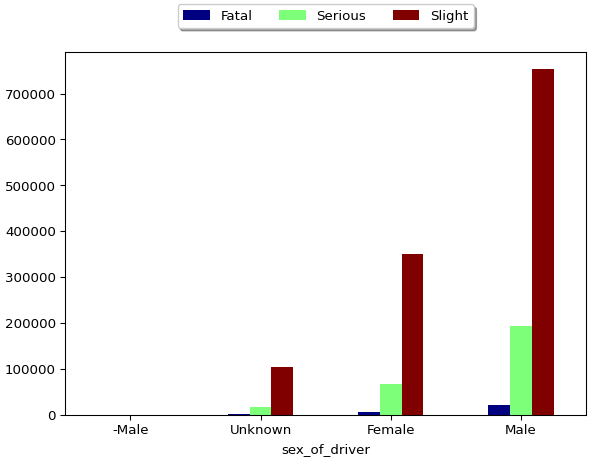

In [35]:
#visualiation for sex_of_driver vs Accident Severity



Accident_sex_of_driver = joined_DF.groupby("sex_of_driver","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_sex_of_driver)




In [ ]:
#visualiation for casualty_home_area_type vs Accident Severity

import numpy as np

Accident_casualty_home_area_type = joined_DF.groupby("casualty_home_area_type","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_casualty_home_area_type)

In [ ]:
# Road type vs accident severity

Accident_type = joined_DF.groupby("road_type","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_type)

In [36]:
# Age band of the driver vs accident count group by accident severity

Accident_count_by_age_band = joined_DF.groupby("age_band_of_driver","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_age_band)

In [ ]:
# Day of Week vs accident count 

Accident_count_by_days = joined_DF.groupby("Day_of_Week","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_days)

In [ ]:
# urban_or_rural_area vs accident count 

Accident_count_by_urban_or_rural_area = joined_DF.groupby("urban_or_rural_area","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_urban_or_rural_area)

In [ ]:
# engine_capacity_cc vs accident count 

Accident_count_by_engine_capacity_cc = joined_DF.groupby("engine_capacity_cc","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_engine_capacity_cc)

In [ ]:
# journey_purpose_of_driver vs accident count 

Accident_count_by_journey_purpose_of_driver = joined_DF.groupby("journey_purpose_of_driver","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_journey_purpose_of_driver)

In [ ]:
# 1st_Point_of_Impact vs accident count 

Accident_count_by_1st_Point_of_Impact = joined_DF.groupby("first_point_of_impact","Accident_Severity") \
                                                        .count().sort("count")
display(Accident_count_by_1st_Point_of_Impact)